In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

test_objects_count = 120

# isNoiseEnable = True
isNoiseEnable = False
noise_scale = 0.03

# isObjectsCountEnable = True
isObjectsCountEnable = False
n = 4.5
objects_count = 3330 - n*60
# objects_count = 3330 - 0

/home/alex/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# PCS only 
# Russia

df = pd.read_csv("Pumps_final_filtered.csv")

df["SN"] = df["SN"].astype(int)
df["Engineer"] = df["Engineer"].astype(str)
df["Customer"] = df["Customer"].astype(str)

In [3]:
if (isObjectsCountEnable == True):
    indexes = np.linspace(0, objects_count, num=objects_count+1)
    df = df.loc[indexes]

In [4]:
df.head()


,Customer,Engineer,SN,Batch,Issue_year,Cost_class,Year,Month,Repair_cost
0,20463233,30,16059,0,2003,1,2011,1,3622.60
1,20439716,10,23805,0,2004,1,2011,1,5174.30
2,20439716,10,23814,0,2004,3,2011,1,43302.46
3,20438512,11,27261,0,2005,2,2011,1,26406.04
4,20438512,11,27922,0,2005,2,2011,1,16358.34


In [5]:
df['Issue_month'] = (df['Issue_year']-2000)*12
df['Repair_month'] = (df['Year']-2000)*12 + df['Month']
df['Usage_coeff'] = df['Repair_month'] / df['Issue_month']


df['Usage_coeff_log']  = [ np.log(i) for i in df.Usage_coeff.values]
# df['Issue_month_log']  = [ np.log(i) for i in df.Issue_month.values]
# df['Repair_month_log'] = [ np.log(i) for i in df.Repair_month.values]
# df['SN_log'] = [ np.log(i) for i in df.SN.values]

df = df.drop(['Issue_year','Month','Year'],axis=1)


In [6]:
df.head()

,Customer,Engineer,SN,Batch,Cost_class,Repair_cost,Issue_month,Repair_month,Usage_coeff,Usage_coeff_log
0,20463233,30,16059,0,1,3622.60,36,133,3.694444,1.306830
1,20439716,10,23805,0,1,5174.30,48,133,2.770833,1.019148
2,20439716,10,23814,0,3,43302.46,48,133,2.770833,1.019148
3,20438512,11,27261,0,2,26406.04,60,133,2.216667,0.796005
4,20438512,11,27922,0,2,16358.34,60,133,2.216667,0.796005


In [7]:
X = df.drop(['Cost_class'],axis=1)
y = df['Cost_class'].values

In [8]:
X_train = X.iloc[:-test_objects_count,:]
X_test = X.iloc[-test_objects_count:,:]

y_train = y[:-test_objects_count]
y_test = y[-test_objects_count:]

In [9]:
def CodeMean(data, old_feature, new_feature):
    return data[old_feature].map(data.groupby(old_feature)[new_feature].mean())

In [10]:

X_train_coded=pd.DataFrame(X_train)
X_test_coded=pd.DataFrame(X_test)

X_train_coded["Mean_customer_repair"] = CodeMean(X_train, "Customer", "Repair_cost")

mean_customer_repair_dict = dict(zip(X_train_coded.Customer, X_train_coded.Mean_customer_repair))

X_test_coded['Mean_customer_repair'] = [mean_customer_repair_dict[c] if c in mean_customer_repair_dict \
                                        else X_train.Mean_customer_repair.mean() for c in X_test_coded.Customer.values]

X_train_coded["Mean_customer_repair_log"] = [ np.log(i) for i in X_train_coded.Mean_customer_repair.values]
X_test_coded["Mean_customer_repair_log"] =  [ np.log(i) for i in X_test_coded.Mean_customer_repair.values]

In [11]:
X_train.Mean_customer_repair.mean()

12259.56478978504

In [12]:
# X_train_coded.head()

In [13]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(sparse=False)


columns=['Engineer', 'Customer']

for col in columns:
    data=X_train[[col]].append(X_test[[col]])
    enc.fit(data)
       # Fitting One Hot Encoding on train data
    temp = enc.transform(X_train[[col]])
       # Changing the encoded features into a data frame with new column names
    temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col].value_counts().index])
       # In side by side concatenation index values should be same
    # Setting the index values similar to the X_train data frame
    temp=temp.set_index(X_train.index.values)
    # adding the new One Hot Encoded varibales to the train data frame
    X_train_coded=pd.concat([X_train_coded,temp],axis=1)
       # fitting One Hot Encoding on test data
    temp = enc.transform(X_test[[col]])
       # changing it into data frame and adding column names
    temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col].value_counts().index])
       # Setting the index for proper concatenation
    temp=temp.set_index(X_test.index.values)
       # adding the new One Hot Encoded varibales to test data frame
    X_test_coded=pd.concat([X_test_coded,temp],axis=1)

In [14]:
X_train_df = pd.DataFrame(X_train_coded).drop(['Customer',
             'Engineer',                          
             'Repair_cost'],axis=1)
# X_train_df.head(10)

In [15]:
# noise_train.shape, X_train_coded.shape

In [16]:
from sklearn.lda import LDA

In [17]:
X_train_coded = X_train_coded.drop(['Customer',
             'Engineer',                          
             'Repair_cost'],axis=1).values


In [18]:
X_test_coded = X_test_coded.drop(['Customer',
             'Engineer',                          
             'Repair_cost'],axis=1).values

In [19]:
# Create noise to binary features

noise_train = np.random.normal(loc=0, scale=noise_scale, size=(X_train_coded.shape[0],X_train_coded.shape[1]-6))
noise_test  = np.random.normal(loc=0, scale=noise_scale, size=(X_test_coded.shape[0],X_test_coded.shape[1]-6))

noise_train_batch = \
    np.random.normal(loc=0, scale=noise_scale, size=(X_train_coded.shape[0]))
    
noise_test_batch  = \
    np.random.normal(loc=0, scale=noise_scale, size=(X_test_coded.shape[0]))

In [20]:
noise_train_batch.shape, X_train_coded[:,1].shape

((3211,), (3211,))

In [21]:
# Adding noise to binary features
if (isNoiseEnable == True):
    X_train_coded[:,6:] = X_train_coded[:,6:] + noise_train
    X_test_coded[:,6:]  = X_test_coded[:,6:]  + noise_test
    
    X_train_coded[:,1] = X_train_coded[:,1] + noise_train_batch
    X_test_coded[:,1]  = X_test_coded[:,1]  + noise_test_batch

In [22]:
X_train_coded.shape,X_test_coded.shape

((3211, 213), (120, 213))

In [23]:
# pd.DataFrame(X_test_coded).head(100)

<function matplotlib.pyplot.show>

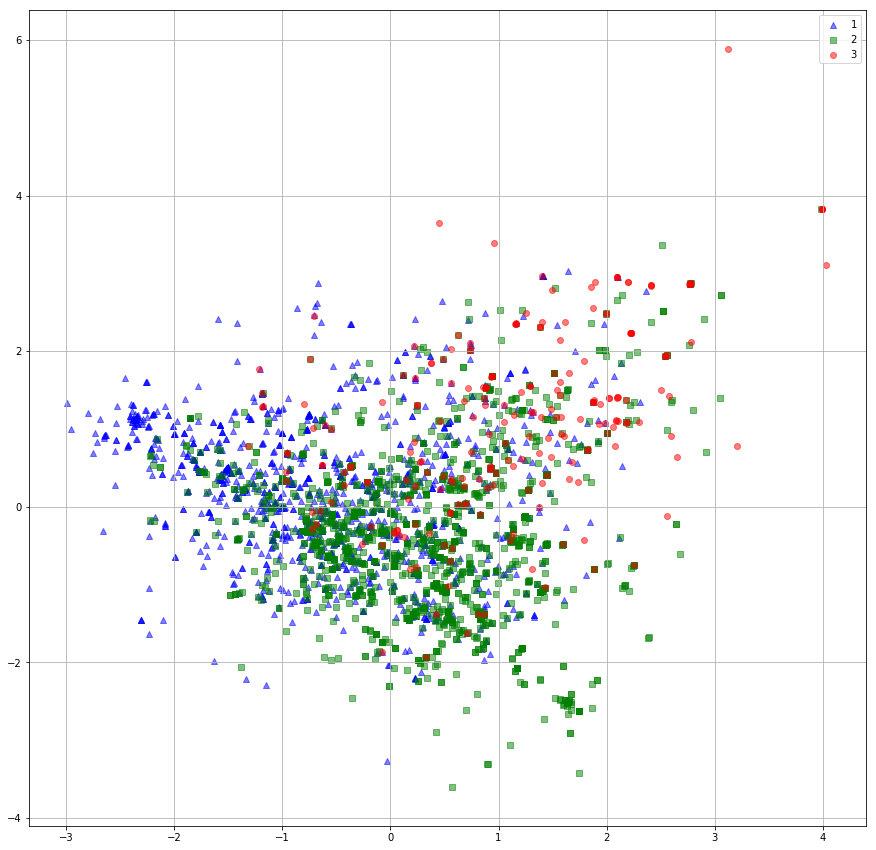

In [26]:
lda = LDA(n_components=2)

X_lda_train = lda.fit_transform(X_train_coded, y_train)

plt.figure(figsize=(15,15))
# ax.set_xlim([-3.5, 4.5])
# ax.set_ylim([-4, 6])
plt.grid()
for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue','green', 'red')):

        plt.scatter(x=X_lda_train[:,0][y_train == label],
                    y=X_lda_train[:,1][y_train == label],
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label)
plt.legend()
plt.show


In [27]:
centroid_mean_1 = X_lda_train[:,0][y_train == 1].mean() , X_lda_train[:,1][y_train == 1].mean()
centroid_mean_2 = X_lda_train[:,0][y_train == 2].mean() , X_lda_train[:,1][y_train == 2].mean()
centroid_mean_3 = X_lda_train[:,0][y_train == 3].mean() , X_lda_train[:,1][y_train == 3].mean()
centroids_mean = [centroid_mean_1, centroid_mean_2, centroid_mean_3]

centroid_var_1 = X_lda_train[:,0][y_train == 1].std() , X_lda_train[:,1][y_train == 1].std()
centroid_var_2 = X_lda_train[:,0][y_train == 2].std() , X_lda_train[:,1][y_train == 2].std()
centroid_var_3 = X_lda_train[:,0][y_train == 3].std() , X_lda_train[:,1][y_train == 3].std()
centroids_var = [centroid_var_1, centroid_var_2, centroid_var_3]

In [28]:
from sklearn.metrics import confusion_matrix
import itertools

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, cm[i, j],
        plt.text(j, i, "{0:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
#
# LDA in new low subspace
#
#

In [31]:

lda2 = LDA()
lda2.fit(X_lda_train,y_train)


LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
  store_covariance=False, tol=0.0001)

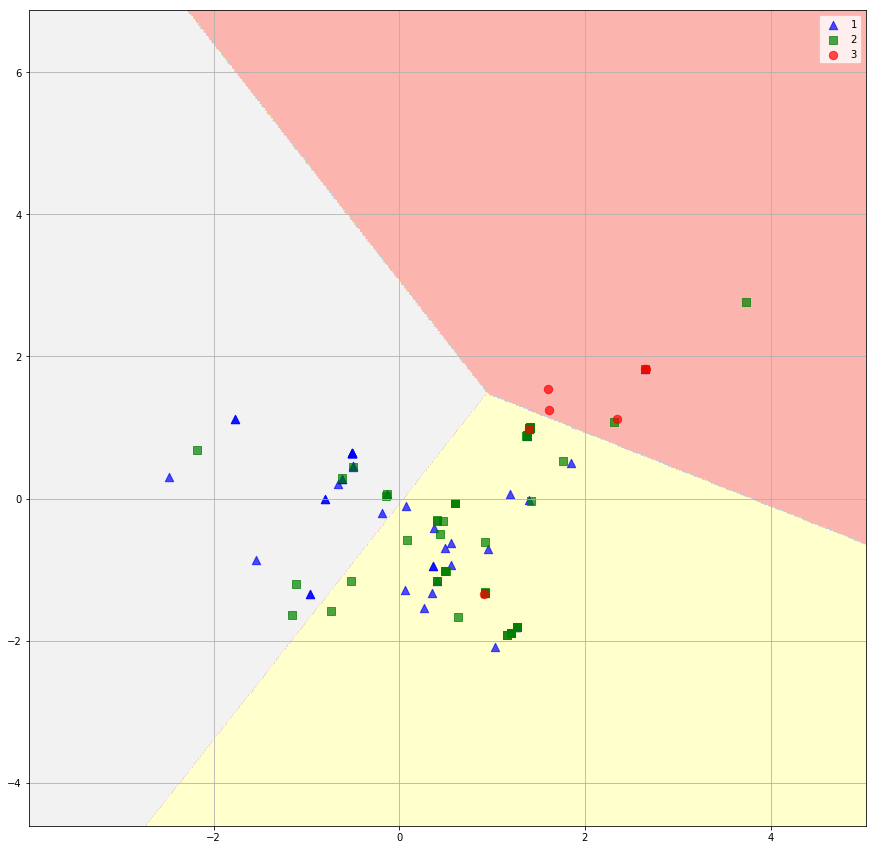

In [32]:
n_classes = 3
plot_step = 0.02
X_lda_test = lda.transform(X_test_coded)

plt.figure(figsize=(15,15))
plt.grid()


x_min, x_max = X_lda_train[:, 0].min() - 1, X_lda_train[:, 0].max() + 1
y_min, y_max = X_lda_train[:, 1].min() - 1, X_lda_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

Z = lda2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z,cmap=plt.cm.Pastel1_r)

for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue','green', 'red')):

        plt.scatter(x=X_lda_test[:,0][y_test == label],
                    y=X_lda_test[:,1][y_test == label] , # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.7,
                    label=label,
                    s=70)
# x = np.linspace(-5,5)        
# plt.scatter(x=x, y = (0.52*x - 0.88)/0.15)
# plt.scatter(x=x, y = (-0.36*x - 0.93)/(-0.35))
# plt.scatter(x=x, y = (-1.14*x - 3.93)/1.15)
plt.legend()
plt.show()

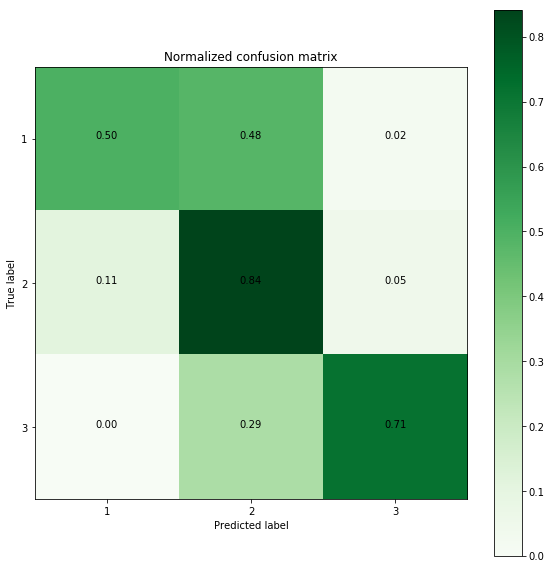

array([[ 0.5       ,  0.48      ,  0.02      ],
       [ 0.11111111,  0.84126984,  0.04761905],
       [ 0.        ,  0.28571429,  0.71428571]])

In [33]:
# Plot confusion matrix
#
#

y_test_predict = lda2.predict(X_lda_test)

cnf_matrix = confusion_matrix(y_test, y_test_predict)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['1','2','3'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()
cnf_matrix

In [34]:
X1_lda = np.array(zip(X_lda_train[:,0][y_train == 1], X_lda_train[:,1][y_train == 1]))
X2_lda = np.array(zip(X_lda_train[:,0][y_train == 2], X_lda_train[:,1][y_train == 2]))
X3_lda = np.array(zip(X_lda_train[:,0][y_train == 3], X_lda_train[:,1][y_train == 3]))

In [35]:
X1_lda_cov = np.cov(X1_lda.T)
X2_lda_cov = np.cov(X2_lda.T)
X3_lda_cov = np.cov(X3_lda.T)

In [36]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    from matplotlib.patches import Ellipse
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    kwargs = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)

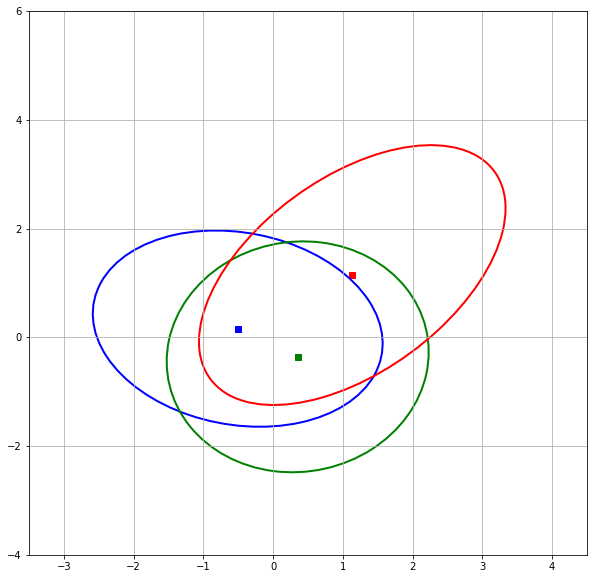

In [37]:
fig = plt.figure(figsize=(10, 10))
plt.grid()
ax = fig.add_subplot(111)
ax.set_xlim([-3.5, 4.5])
ax.set_ylim([-4, 6])
plot_cov_ellipse(X1_lda_cov,[centroids_mean[0][0],centroids_mean[0][1]],ax=ax, ec='blue',nstd=2)
plot_cov_ellipse(X2_lda_cov,[centroids_mean[1][0],centroids_mean[1][1]],ax=ax, ec='green',nstd=2)
plot_cov_ellipse(X3_lda_cov,[centroids_mean[2][0],centroids_mean[2][1]],ax=ax, ec='red',nstd=2)
plt.scatter(centroids_mean[0][0],centroids_mean[0][1], marker='s',color='blue')
plt.scatter(centroids_mean[1][0],centroids_mean[1][1], marker='s',color='green')
plt.scatter(centroids_mean[2][0],centroids_mean[2][1], marker='s',color='red')

# plt.scatter(x=X_lda_train[:,0][y_train == 3],
#                     y=X_lda_train[:,1][y_train == 3],color='red',alpha=0.7)
# plt.scatter(x=X_lda_train[:,0][y_train == 1],
#                     y=X_lda_train[:,1][y_train == 1],color='blue',alpha=0.4)
# plt.legend()

In [38]:
# plt.figure(figsize=(15,15))
# plt.grid()
# plt.scatter(x=X_lda_train[:,0][y_train == 1],
#                     y=X_lda_train[:,1][y_train == 1],color='blue',alpha=0.4)
# plt.scatter(x=X_lda_train[:,0][y_train == 3],
#                     y=X_lda_train[:,1][y_train == 3],color='red',alpha=0.7)

In [39]:
cf_total = np.array([[ 0.52015591,  0.44384671,  0.03599737],
       [ 0.26922172,  0.69425105,  0.03652723],
       [ 0.07674814,  0.42565081,  0.49760105]])

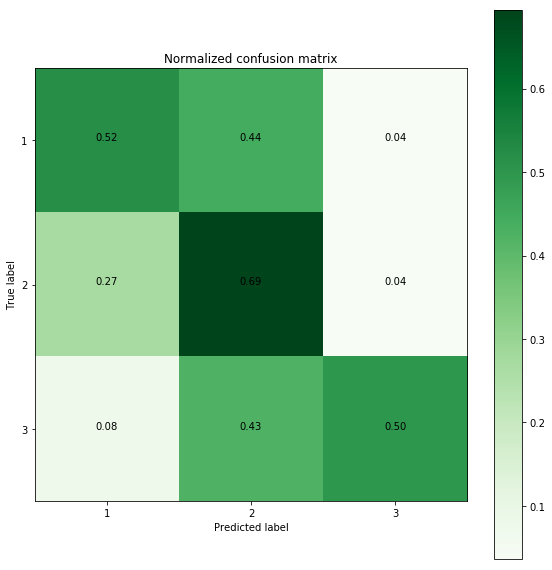

In [40]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cf_total, classes=['1','2','3'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
(52+69+50)/3.0